# Telecom: Identifying Ineffective Operators

The virtual telephony service CallMeMaybe is developing a new function that will give supervisors information on the least effective operators. An operator is considered ineffective if they have:
- a large number of missed incoming calls (internal and external) and 
- a long waiting time for incoming calls. 
- Moreover, if an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness.

## Goal:

Identify ineffective operators.

## Contents:

- [Step 1. Open the data files and study the general information](#step1)
- [Step 2. Prepare data](#step2)
- [Step 3. Exploratory data analysis](#step3)
- [Step 4. Cluster analysis](#step4)
- [Step 5. Ineffective operators analysis](#step5)
- [Step 6. Make conclusions.](#step6)
- [References](#ref)

<a id='step1'></a>

## Step 1. Open the data files and study the general information

- Study general information on the datasets with info() method
- Check for missing values
- Check for duplicates
- Check data types and if conversion is needed
- Find and eliminate errors in the data if any. We need to check that:
    - Client registration date is earlier than calls made by its operators
    - Total call duration should be more than call duration
    - Clients didn't change tariffs.
    - Client ids match each other in both datasets
    - Check for zero values for duration and make a decision on these records
    
    

In [1]:
!pip install seaborn --upgrade --quiet
!pip install squarify --quiet

In [2]:
# Import necesary modules
import pandas as pd
import numpy as np
import math as mth
import matplotlib
import matplotlib.pyplot as plt
import pytz
import seaborn as sns
import plotly.graph_objects as go
from scipy import stats as st
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import squarify

In [3]:
# Load data
calls = pd.read_csv('telecom_dataset_us.csv')
clients = pd.read_csv('telecom_clients_us.csv')

- Study general information on the calls with info() method
- Check for missing values

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


### Comments:
- We've got missing values for **'internal'** and **'operator_id'** fields
- we might need a data type conversion for the date field (see below)

Let's look in detail what the missing values are.
First query for missing 'operator_id' field.

In [5]:
calls[calls['operator_id'].isna()].sample(5)

user_id                       date direction internal  operator_id  \
49863   168221  2019-11-24 00:00:00+03:00        in    False          NaN   
40074   167799  2019-10-17 00:00:00+03:00        in    False          NaN   
40173   167799  2019-11-10 00:00:00+03:00        in    False          NaN   
15402   166899  2019-09-02 00:00:00+03:00        in    False          NaN   
30307   167338  2019-09-19 00:00:00+03:00        in    False          NaN   

       is_missed_call  calls_count  call_duration  total_call_duration  
49863            True            3              0                    7  
40074            True            1              0                   54  
40173            True            3              0                   27  
15402            True            1              0                    2  
30307            True            1              0                  156

Seems that records are missing mainly for external incoming calls with 0 duration which were missed. Let's check it. 

In [6]:
calls[calls['operator_id'].isna()]['direction'].value_counts()

in     7972
out     200
Name: direction, dtype: int64

In [7]:
calls[calls['operator_id'].isna()]['internal'].value_counts()

False    7760
True      355
Name: internal, dtype: int64

In [8]:
calls[calls['operator_id'].isna()]['is_missed_call'].value_counts()

True     8050
False     122
Name: is_missed_call, dtype: int64

In [9]:
calls[calls['operator_id'].isna()]['call_duration'].describe()

count     8172.000000
mean        66.013828
std        954.840945
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      26175.000000
Name: call_duration, dtype: float64

In [10]:
# Get the number of external incoming calls with zero duration
calls.query('call_duration==0 and is_missed_call==True and direction=="in" and internal==False')[['user_id', 'operator_id']].count()

user_id        7970
operator_id     434
dtype: int64

In [11]:
# Get the number of records with missing operator_id values.
calls[calls['operator_id'].isna()]['user_id'].count()

8172

### Comments:

Mainly the missing values for 'operator_id' field relate to external incoming calls with 0 duration which were missed but there's a small portion of other call types (external, outgoing, not missed). Out of 8172 missing values for operator_id there're 7536 (= 7970 - 434) records for external incoming calls with 0 duration which were missed.

Now let's check missing values for 'internal' field while operator_id is present.

In [12]:
calls[(calls['internal'].isna()) & ~(calls['operator_id'].isna())].sample(5)

user_id                       date direction internal  operator_id  \
29989   167272  2019-10-09 00:00:00+03:00        in      NaN     912684.0   
6216    166541  2019-09-26 00:00:00+03:00        in      NaN     908958.0   
38069   167650  2019-10-14 00:00:00+03:00        in      NaN     921318.0   
32590   167466  2019-11-26 00:00:00+03:00        in      NaN     921818.0   
43256   167977  2019-11-25 00:00:00+03:00        in      NaN     944216.0   

       is_missed_call  calls_count  call_duration  total_call_duration  
29989           False            1            123                  175  
6216            False            2            547                  612  
38069           False            1            136                  145  
32590           False            1             15                   81  
43256           False            1            206                  230

In [13]:
calls[(calls['internal'].isna()) & ~(calls['operator_id'].isna())]['direction'].value_counts()

in    60
Name: direction, dtype: int64

In [14]:
calls[(calls['internal'].isna()) & ~(calls['operator_id'].isna())]['is_missed_call'].value_counts()

False    59
True      1
Name: is_missed_call, dtype: int64

In [15]:
calls[(calls['internal'].isna()) & ~(calls['operator_id'].isna())]['call_duration'].describe()

count     60.000000
mean     119.750000
std      173.611453
min        1.000000
25%       22.250000
50%       75.500000
75%      123.250000
max      960.000000
Name: call_duration, dtype: float64

In [16]:
# calls_count distribution
calls[(calls['internal'].isna()) & ~(calls['operator_id'].isna())]['calls_count'].describe()

count    60.000000
mean      1.083333
std       0.334039
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: calls_count, dtype: float64

In [17]:
# the number of records with calls_count==1
calls[(calls['calls_count']==1) & ~(calls['operator_id'].isna())][['user_id','internal']].count()

user_id     11499
internal    11443
dtype: int64

### Comments:
Out of 60 missing values for 'internal' field (while operator_id is present) 56 values relate to calls_count==1. As to other parameters these are typical call center calls (incoming not missed calls with a wide duration range). There's no pattern for such mising values.

Let's get rid of the missing values.

In [18]:
calls_good = pd.DataFrame(calls[(~calls['internal'].isna()) & (~calls['operator_id'].isna())])

- Check data types and if conversion is needed

In [19]:
calls_good.head()

user_id                       date direction internal  operator_id  \
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   
5   166377  2019-08-05 00:00:00+03:00       out    False     880020.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  
5           False            2              3                   29

In [20]:
calls_good['internal'].value_counts()

False    39861
True      5809
Name: internal, dtype: int64

In [21]:
calls_good['direction'].value_counts()

out    31717
in     13953
Name: direction, dtype: int64

### Comments:
- **'date'** field requires conversion  into datetime type.
- **'internal'** field should be converted into bool
- **'direction'** field values can be replaced with numeric values (e.g. 'in' -> 0, 'out'-> 1) for further analysis.

Let's make the conversions.

In [22]:
# convert date column to datetime
calls_good['date'] = pd.to_datetime(calls['date'])
# convert internal to bool
calls_good['internal'] = calls['internal'].astype('bool')
# convert replace string values for direction converting to int
calls_good['direction'] = calls_good['direction'].replace('in',0)
calls_good['direction'] = calls_good['direction'].replace('out',1)

- Check for duplicates

In [23]:
calls_good.duplicated().sum()

4179

It's a low propability that all columns simultaneously have the same values for different call events (especially duration paramters). 
Let's look at the dates distributions (and some other parameters) for the duplicates to understand if it was a temporary issue or systematic error that caused the repeating records.

In [24]:
# look at the timeframe
calls_good[calls_good.duplicated()]['date'].describe()

count                          4179
unique                          114
top       2019-11-18 00:00:00+03:00
freq                            105
first     2019-08-05 00:00:00+03:00
last      2019-11-28 00:00:00+03:00
Name: date, dtype: object

In [25]:
# get the difference between the endpooints of the interval
calls_good[calls_good.duplicated()]['date'].describe()['last']- calls_good[calls_good.duplicated()]['date'].describe()['first']

Timedelta('115 days 00:00:00')

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



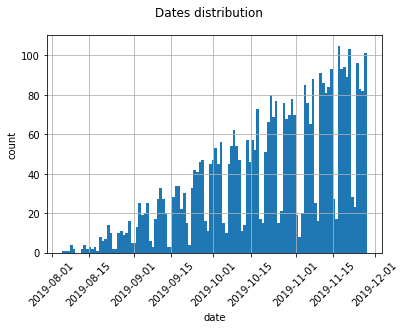

In [26]:
# use the interval for the bins parameter
ax = calls_good[calls_good.duplicated()]['date'].hist(bins = 116)
b = plt.xticks(rotation='45')
b = plt.xlabel("date")
b = plt.ylabel("count")
b = plt.suptitle("Dates distribution")

In [27]:
calls_good[calls_good.duplicated()].describe(include="all")

user_id                       date    direction internal  \
count     4179.000000                       4179  4179.000000     4179   
unique            NaN                        114          NaN        2   
top               NaN  2019-11-18 00:00:00+03:00          NaN    False   
freq              NaN                        105          NaN     3700   
first             NaN  2019-08-05 00:00:00+03:00          NaN      NaN   
last              NaN  2019-11-28 00:00:00+03:00          NaN      NaN   
mean    167310.925820                        NaN     0.694903      NaN   
std        604.027994                        NaN     0.460504      NaN   
min     166377.000000                        NaN     0.000000      NaN   
25%     166782.000000                        NaN     0.000000      NaN   
50%     167176.000000                        NaN     1.000000      NaN   
75%     167828.000000                        NaN     1.000000      NaN   
max     168606.000000                        NaN     1.000000      NaN   

          operator_id is_missed_call  calls_count  call_duration  \
count     4179.000000           4179  4179.000000    4179.000000   
unique            NaN              2          NaN            NaN   
top               NaN          False          NaN            NaN   
freq              NaN           2771          NaN            NaN   
first             NaN            NaN          NaN            NaN   
last              NaN            NaN          NaN            NaN   
mean    916653.678871            NaN    16.963149    1010.878679   
std      21500.573340            NaN    51.568065    3487.419059   
min     879896.000000            NaN     1.000000       0.000000   
25%     900423.000000            NaN     2.000000       0.000000   
50%     913942.000000            NaN     4.000000     115.000000   
75%     937746.000000            NaN    14.000000     793.500000   
max     972460.000000            NaN  1241.000000   80782.000000   

        total_call_duration  
count           4179.000000  
unique                  NaN  
top                     NaN  
freq                    NaN  
first                   NaN  
last                    NaN  
mean            1329.095717  
std             4166.245402  
min                0.000000  
25%               72.500000  
50%              310.000000  
75%             1166.000000  
max           100139.000000

## Comments
- It seems that duplicates are caused by a systematic error (the error occured during 4 months)
- Parameters have a wide range of values for duplicated records meaning duplication is not related to a specific call type.
- We can safely delete duplicated records.

Let's get rid of duplicates.

In [28]:
calls_good = calls_good.drop_duplicates()

- Study general information on the clients dataset with info() method
- Check for missing values

In [29]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


### Comments:
- No missing values so far.


- Check data types and if conversion is needed

In [30]:
clients.head()

user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16

### Comments:
- **'date_start'** field requires conversion  into datetime type.

Let's make the conversion and add TZ as in the calls file.

In [31]:
clients['date_start'] = pd.to_datetime(clients['date_start'])
clients['date_start'] = clients['date_start'].dt.tz_localize(tz=pytz.FixedOffset(180))

- Check for duplicates

In [32]:
clients.duplicated().sum()

0

### Comments:
- No duplicated values so far.


- Find and eliminate errors in the data if any. We need to check that:
    - Client registration date is earlier than calls made by its operators
    - Total call duration should be more than call duration
    - Clients didn't change tariffs.
    - Client ids match each other in both datasets
    - Check for zero values for duration and make a decision on these records
    
First, let's merge 2 datasets on the only common field 'user_id'   

In [33]:
calls_tariff = calls_good.merge(clients)

- Check that no records with client registration date following calls made by its operators

In [34]:
calls_tariff[calls_tariff['date_start'] > calls_tariff['date']].shape[0]

0

- Check that no records with total call duration less than call duration

In [35]:
calls_tariff[calls_tariff['total_call_duration'] < calls_tariff['call_duration']].shape[0]

0

- Clients didn't change tariffs.

In [36]:
tariffs = clients.groupby('user_id')['tariff_plan'].count()
tariffs[tariffs>1].shape[0]

0

- Client ids match each other in both datasets: check that there're no users in the calls dataset missing from the clients dataset.

In [37]:
ids =clients['user_id'].unique()
calls_good.query('user_id not in @ids').shape[0]

0

- Check for zero values for duration and make a decision on this records

In [38]:
((calls_tariff['call_duration']==0) | (calls_tariff['total_call_duration']==0)).sum()

13831

In [39]:
calls_tariff[(calls_tariff['call_duration']==0) | (calls_tariff['total_call_duration']==0)].sample(5)

user_id                      date  direction  internal  operator_id  \
14829   166983 2019-11-12 00:00:00+03:00          0     False     901880.0   
20583   167172 2019-09-17 00:00:00+03:00          1     False     904202.0   
33906   168047 2019-11-28 00:00:00+03:00          1     False     937604.0   
208     166377 2019-09-23 00:00:00+03:00          1      True     880028.0   
20646   167172 2019-10-30 00:00:00+03:00          1     False     904204.0   

       is_missed_call  calls_count  call_duration  total_call_duration  \
14829            True            1              0                   13   
20583            True            8              0                  230   
33906            True            2              0                   60   
208              True            1              0                    2   
20646            True            1              0                   66   

      tariff_plan                date_start  
14829           C 2019-08-27 00:00:00+03:00  
20583           B 2019-09-05 00:00:00+03:00  
33906           B 2019-10-10 00:00:00+03:00  
208             B 2019-08-01 00:00:00+03:00  
20646           B 2019-09-05 00:00:00+03:00

Seems that zero call duration is for missed calls. Let's check.

In [40]:
(calls_tariff['is_missed_call']==True).sum()

14109

In [41]:
((calls_tariff['is_missed_call']==True) & (calls_tariff['direction']==0)).sum()

684

In [42]:
(((calls_tariff['call_duration']==0) | (calls_tariff['total_call_duration']==0)) & (calls_tariff['is_missed_call']==True)).sum()

13814

In [43]:
(~((calls_tariff['call_duration']==0) | (calls_tariff['total_call_duration']==0)) & (calls_tariff['is_missed_call']==True)).sum()

295

In [44]:
calls_tariff[(~((calls_tariff['call_duration']==0) | (calls_tariff['total_call_duration']==0)) & (calls_tariff['is_missed_call']==True))].sample(5)

user_id                      date  direction  internal  operator_id  \
17397   167071 2019-11-07 00:00:00+03:00          0     False     913942.0   
39151   168252 2019-11-23 00:00:00+03:00          0     False     940622.0   
38592   168252 2019-10-18 00:00:00+03:00          0      True     940616.0   
12413   166916 2019-10-16 00:00:00+03:00          0     False     906392.0   
35257   168091 2019-11-14 00:00:00+03:00          0     False     958434.0   

       is_missed_call  calls_count  call_duration  total_call_duration  \
17397            True            1              1                   17   
39151            True            1            269                  274   
38592            True            1             31                   34   
12413            True            5            327                  397   
35257            True            1             14                   27   

      tariff_plan                date_start  
17397           B 2019-08-30 00:00:00+03:00  
39151           A 2019-10-17 00:00:00+03:00  
38592           A 2019-10-17 00:00:00+03:00  
12413           A 2019-08-23 00:00:00+03:00  
35257           B 2019-10-14 00:00:00+03:00

## Comments:

- 13814 out of 13831 zero duration calls are missed calls. Just 410 of missed calls are incoming.
- missed calls not necessarily have a zero duration (there're 295 records).
- there're zero duration calls which are not missed (just 17 records). Perhaps, the operator answered and at the same time the calling party released the call. 

The missed calls with non-zero duration look strange: we need to clarify the roots of it. 
Possible reasons:
- it's a voicemail duration. But as a rule calls are diverted to voicemail after a certain timeout (waiting time should be fixed). For such records we see that the waiting time varies. It can be also that the caller picked up voicemail option from the IVR himself. In this scenario it admits different waiting times
- It's a technical error a the call should not be considered as missed.

For our analysis let's change is_missed_call values to False for the strange records.

In [45]:
calls_tariff.loc[~((calls_tariff['call_duration']==0) | (calls_tariff['total_call_duration']==0)) & (calls_tariff['is_missed_call']==True), 'is_missed_call'] = False

- Check that operators are not shared among clients.

In [46]:
calls_tariff.groupby('operator_id')['user_id'].nunique().max()

1

A particular operator belongs to only one client (user_id).

## Conclusions:

- We've found and deleted missing values in the calls dataset. 
- Values were missing for operator_id and internal fields. 
- The missing values mainly relate to external incoming calls with 0 duration which were missed.
- We've found and deleted duplicated records in the calls dataset. 
- Duplicates relate to a systematic error occured for the entire period the data covers.
- We've detected non-zero duration calls which were missed. The 'is_missed_call' column has been fixed for such records.
- We've made necessary conversions for date fields and for a boolean field. Also we've replaced string values for the 'direction' field with numbers to make it numeric to be able to apply analysis.


<a id='step2'></a>

## Step 2. Prepare data

- Make a dataset with clean data (without missing values and logical errors).

<font color='green'>Done in the previous step.</font>
- Replace 'direction' field string values with numbers 0 (in) and 1 (out) to use them further.

<font color='green'>Done in the previous step.</font>

- Add truncated date (without hours/mins/seconds) and month columns.
- Add 'waiting time' column as a difference between 'total duration' and 'call duration'.

<font color='red'>Need to accompish these 2 tasks. 👆</font>

- Merge datasets on user_id.

<font color='green'>Done in the previous step.</font>


- Add truncated date (without hours/mins/seconds) and month columns.

In [47]:
calls_tariff['date_trunc'] = calls_tariff['date'].dt.date
calls_tariff['month'] = calls_tariff['date'].dt.month

- Add 'waiting time' column as a difference between 'total duration' and 'call duration'.

In [48]:
calls_tariff['waiting_time'] = calls_tariff['total_call_duration'] - calls_tariff['call_duration']

## Conclusions:

- We've added supplementary columns for further analysis.
    - date_trunc
    - month
    - waiting_time

<a id='step3'></a>

## Step 3. Exploratory data analysis

### General analysis

- Calculate the number of Clients. 
- Calculate the number of operators per each client. Get TOP10 clients.
- Study call duraion distribution.
- Study waiting time distribution.
- Calculate shares of internal and external calls.
- Study the number of calls per day distribution.
- Calculate the share of missed incoming calls.
- Calculate the share of outgoing and incoming calls.


- Calculate the number of Clients.

In [49]:
# The number of clients in the clients dataset
len(clients['user_id'].unique())

732

In [50]:
# The number of clients in the calls dataset
len(calls_good['user_id'].unique())

290

## Comments:

The overall number of service clients is 732 but we'll consider only 290 of them for those we have good calls data.

- Calculate the number of operators per each client. Get TOP10 clients.

In [51]:
user_opcount = calls_tariff.groupby('user_id')['operator_id'].nunique().sort_values(ascending=False)
user_opcount.head(10)

user_id
168187    50
167626    48
167497    30
168252    28
168062    27
168361    27
166680    21
166520    18
166658    17
168091    16
Name: operator_id, dtype: int64

In [52]:
user_opcount.describe()

count    290.000000
mean       3.765517
std        5.717712
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       50.000000
Name: operator_id, dtype: float64

In [53]:
calls_tariff['operator_id'].nunique()

1092

## Comments:

- The biggest clients have up to ~50 operators
- There're also small clients having just 1 operator
- at least 50% of clients have not more than 2 operators.
- 75% of clients have not more than 4 operators.
- The total number of operators is 1092.

- Study call duration distribution.

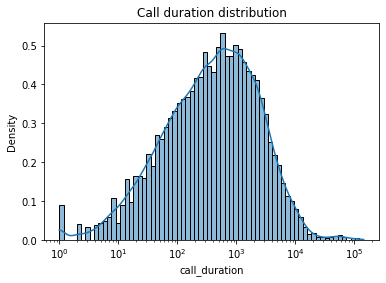

In [54]:
ax = sns.histplot(calls_tariff[calls_tariff['call_duration']>0]['call_duration'],log_scale=True, kde=True, stat='density').set_title('Call duration distribution')

In [55]:
# consider all calls (including missed calls)
calls_tariff['call_duration'].describe()

count     41491.000000
mean       1010.940011
std        4066.666485
min           0.000000
25%           0.000000
50%         106.000000
75%         772.000000
max      144395.000000
Name: call_duration, dtype: float64

In [56]:
# consider non-zero duration calls
calls_tariff[calls_tariff['call_duration']>0]['call_duration'].describe()

count     27660.000000
mean       1516.446565
std        4903.158159
min           1.000000
25%         106.000000
50%         435.000000
75%        1401.000000
max      144395.000000
Name: call_duration, dtype: float64

## Comments:

- At least 25% of calls have 0 call duration (looks like missed calls).
- The median call duration (among non-missed calls) is ~7 minutes while mean value ~25 minutes with standard deviation of ~1 hour 20 minutes meaning a heavy tail to the right.
- According to some public sources[<sup>1</sup>](#fn1): `4 minutes is an average duration of a call.` Median value is closer to this value than mean value. Generally we've got reasonable numbers.

- Study waiting time distribution for **all calls**.

In [57]:
# Check if zero waiting time relates to real calls or to missed calls
calls_tariff.query('waiting_time==0').groupby('is_missed_call')['operator_id'].count()

is_missed_call
False     30
True     861
Name: operator_id, dtype: int64

In most cases zero value for waiting time means that the call was missed, so we'll exclude this value not to distort the results of the real calls.

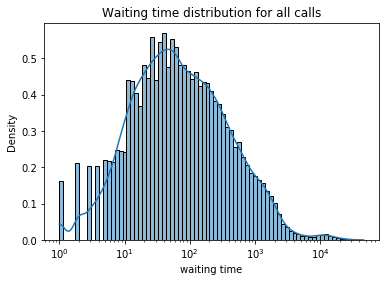

In [58]:
ax = sns.histplot(calls_tariff[calls_tariff['waiting_time']>0]['waiting_time'],
                  log_scale=True, 
                  kde=True, 
                  stat='density').set_title('Waiting time distribution for all calls')
b = plt.xlabel("waiting time")

In [59]:
calls_tariff['waiting_time'].describe()

count    41491.000000
mean       312.213227
std       1176.102940
min          0.000000
25%         19.000000
50%         60.000000
75%        219.000000
max      46474.000000
Name: waiting_time, dtype: float64

## Comments:

- We've got 60s median waiting time while mean waiting time is ~5 minutes for all calls distribution.
- According to some public sources[<sup>1</sup>](#fn1): `28 seconds is the average waiting time to contact the operator`. Our distribution concerns all kinds of calls (incoming and outgoing) so let's consider distribution just for incoming calls.

- Study waiting time distribution for **incoming calls**.

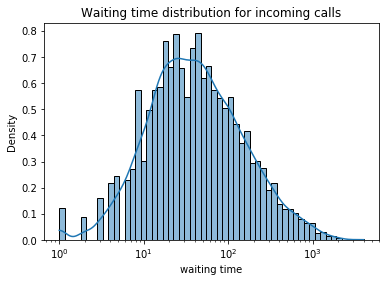

In [60]:
ax = sns.histplot(calls_tariff[(calls_tariff['waiting_time']>0) & (calls_tariff['direction']==0)]['waiting_time'],
                  log_scale=True, 
                  kde=True, 
                  stat='density').set_title('Waiting time distribution for incoming calls')
b = plt.xlabel("waiting time")

In [61]:
calls_tariff[(calls_tariff['waiting_time']>0) & (calls_tariff['direction']==0)]['waiting_time'].describe()

count    12669.000000
mean        97.268845
std        185.642233
min          1.000000
25%         17.000000
50%         38.000000
75%         97.000000
max       3998.000000
Name: waiting_time, dtype: float64

## Comments:

- We've got results closer to the results from the public source: 38s median and 97s mean (and 3Q) value with standard deviation of ~3 minutes for waiting time for incoming calls (a heavy tail to the right).

- Calculate shares of internal and external calls.

For the number of calls calculation we'll not take into account calls_count parameter as we treat it as the number of attempts preceding the actual call.

In [62]:
labels = ['external','internal']

values= calls_tariff.groupby('internal')['operator_id'].count()
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title="Internal vs. External calls",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)


## Comments:

Mainly operators handle external calls (~87%) making just ~13% of internal calls

- Study the number of calls per day distribution.

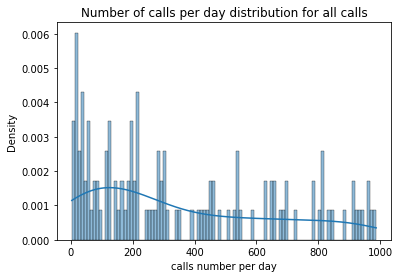

In [63]:
ax = sns.histplot(calls_tariff.groupby('date')['operator_id'].count(),
                  bins=100, 
                  kde=True, 
                  stat='density')
ax.set_title('Number of calls per day distribution for all calls')
b=ax.set(xlabel='calls number per day')

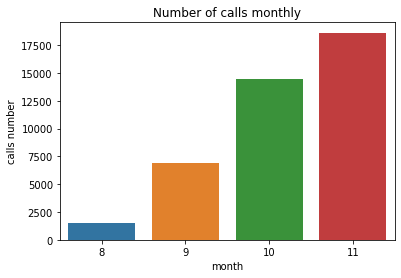

In [64]:
calls_num_date = calls_tariff.groupby('month')['operator_id'].count()
ax = sns.barplot(x=calls_num_date.index ,y=calls_num_date)
b=ax.set_title('Number of calls monthly')
b=ax.set(ylabel='calls number')

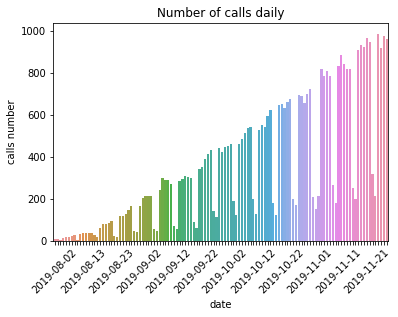

In [65]:
calls_num_date = calls_tariff.groupby('date_trunc')['operator_id'].count()
ax = sns.barplot(x=calls_num_date.index ,y=calls_num_date)
ax.set_title('Number of calls daily')
ax.set(xlabel='date', ylabel='calls number')
b = plt.xticks(rotation=45)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

## Comments:

- the daily and monthly number of calls is growing with time. It seems the business is growing.
- we observe holes between dense regions on the bar plot. It can be weekend's low activity.
- the 'number of calls' distribution reminds uniform distribution (with several narrow peaks) as it had a steady growth .

- Calculate the share of missed incoming calls among all incoming calls.

In [66]:
labels = ['missed incoming','other']
missed_in = calls_tariff.query('is_missed_call == True and direction==0')['operator_id'].count()
other = calls_tariff.query('is_missed_call == False and direction==0')['operator_id'].count()
values = [missed_in, other]
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title="Missed incoming vs. other calls",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)


## Comments:

Missed incoming calls are ~3.2% of all incoming calls which is a good indicator for general performance. According to Talkdesk's information[<sup>5</sup>](#fn5): `Average abandonment rate is 12%`

- Calculate the share of outgoing and incoming calls.

In [67]:
labels = ['incoming','outgoing']

values = calls_tariff.groupby('direction')['operator_id'].count()
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title="Incoming vs. Outgoing calls",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)


## Comments:

- Just ~30% of all calls are incoming calls served by the operators. The rest are outgoing calls.

- Study the number of outgoing calls distribution among operators who are supposed to make outgoing calls.

In [68]:
out_count = calls_tariff.groupby('operator_id')['direction'].sum()


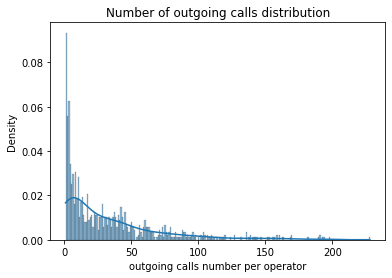

In [69]:
ax = sns.histplot(out_count[out_count>0],
                  bins=228, 
                  kde=True, 
                  stat='density')
ax.set_title('Number of outgoing calls distribution')
b=ax.set(xlabel='outgoing calls number per operator')

In [70]:
out_count[out_count>0].describe()

count    882.000000
mean      32.667800
std       38.145841
min        1.000000
25%        5.000000
50%       19.000000
75%       45.000000
max      228.000000
Name: direction, dtype: float64

## Comments:

- 50% of operators who are supposed to make outgoing calls made more than 19 calls over all the time period while max outgoing calls number per operator is 228 which is low for a 4-months period (it means in average ~2 calls per day). It seems that operators rarely make calls but the duration of the calls as we saw above can be quite long.
- 25% of operators made more that 5 and less than 19 outgoing calls while other 25% made no more than 5 calls.


## Conclusions for general analysis

- We consider 290 clients with 1092 operators distributed among them.
- Typically a client has from 1 to 4 operators.
- Missed incoming calls have a share of ~3.2% of all incoming calls. 
- Waiting time for incoming calls has 38s median and 97s mean (and 3Q) values. As a preliminary criteria for ineffective operators we can take waiting time of more than 3Q value (**97s**).
- As for outgoing calls: generally operators make rare outgoing calls (for the operator with max outgoing calls count on average 2 per day). Below we'll look at the outgoing calls share on per month basis to be more accurate.

### Per client/operator analysis

- Calculate mean waiting time per client/operator per day/month (use groupby() method).
- Calculate mean calls number per client/operator per day/month (use groupby() method).
- Calculate mean share of missed calls per client/operator per day/month (use groupby() method).
- Calculate mean share of outgoing calls per client/operator per day/month (use groupby() method).
- Study  mean daily waiting time distribution for each tariff and build histograms. 
- Make a statistical test: check if waiting times differ among tariffs. 

Test the following null-hypothesis $H_0$: mean waiting times are equal for all tariff plans. 
- Build a correlation matrix and display it

For TOP10 clients build and study:
- mean waiting time distribution.
- the number of calls per day distribution.
- mean share of missed calls distribution.
- mean share of outgoing calls distribution.

- Based on distributions analysis make a decision:
    - what waiting time should be considered long to be ineffective
    - what share of missed incoming calls is considered ineffective
    - what share of outgoing calls is sign of ineffectiveness
    - are the above values universal or depend on client?


- Calculate mean waiting time (for incoming calls) per client/operator during day/month (use groupby() method).

In [71]:
# calculate mean values during month
calls_WT_monthly = calls_tariff.query('direction==0 and waiting_time>0').groupby(['user_id','operator_id', 'month']).agg({'waiting_time':'mean', 'tariff_plan': 'first'})
calls_WT_monthly.head()

waiting_time tariff_plan
user_id operator_id month                          
166377  880020.0    8         16.000000           B
                    9          6.333333           B
        880022.0    10        18.000000           B
                    11        13.428571           B
        880026.0    8         10.666667           B

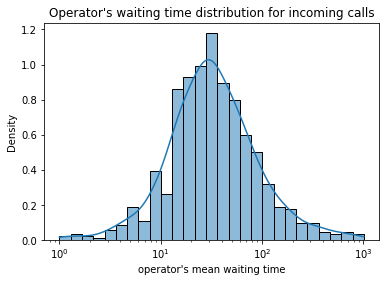

In [72]:
calls_WT_operator = calls_tariff.query('direction==0 and waiting_time>0').groupby(['user_id','operator_id']).agg({'waiting_time':'mean', 'tariff_plan': 'first'})
ax = sns.histplot(calls_WT_operator['waiting_time'],
                  log_scale=True, 
                  kde=True, 
                  stat='density').set_title("Operator's waiting time distribution for incoming calls")
b = plt.xlabel("operator's mean waiting time")

In [73]:
calls_WT_operator['waiting_time'].describe()

count     754.000000
mean       58.083206
std        96.516557
min         1.000000
25%        17.500000
50%        31.000000
75%        58.000000
max      1007.375000
Name: waiting_time, dtype: float64

Compared to general analysis per operator waiting time has lower values for statistics:

median = **31s** and 3Q = **58s** and std = **96s**

We can identify ineffective operators looking for operators whose average monthly waiting time does not drop below the threshold of 60 s.


In [74]:
# filter based on monthly min waiting time and get the size of the group
min_WT_month = calls_WT_monthly.reset_index().groupby('operator_id')['waiting_time'].min()
filtered_min_WT_month = min_WT_month[min_WT_month>60]
filtered_min_WT_month.count()

125

Let's search for daily mean waiting time which is above mean value from general analysis. So we'll find operators systematically having long waiting time.
Additionally we'll look for operators whose average waiting time more than the average value over the dataset.

In [75]:
# for each operator get daily mean waiting time for incoming calls 
daily_WT = calls_tariff.query('direction==0 and waiting_time>0').groupby(['operator_id', 'date_trunc']).agg({'waiting_time':'mean', 'tariff_plan': 'first'})
# get mean waiting time and min average daily waiting time 
mean_WT = calls_tariff.query('direction==0 and waiting_time>0').groupby(['operator_id']).agg({'waiting_time':'mean', 'tariff_plan': 'first'})
min_WT = daily_WT.reset_index().groupby('operator_id')['waiting_time'].min()
# filter operators whose min daily WT value > mean value for waiting time we've got above
filtered_min_WT = min_WT[min_WT>97]
# get operators whose mean waiting time is above the threshold of mean
filtered_mean_WT = mean_WT[mean_WT['waiting_time']>97]
# the size of the 1st group of operators filtered based on median
filtered_min_WT.count()

11

In [76]:
# the size of the 2nd group of operators filtered based on mean
filtered_mean_WT['waiting_time'].count()

95

In [77]:
# the size of the 2nd group not including the 1st group
len(set(filtered_mean_WT.index) - set(filtered_min_WT.index))

84

In [78]:
# Look for unique operators in month-based filtering
len(set(filtered_min_WT_month.index)-set(filtered_mean_WT.index) - set(filtered_min_WT.index))

48

We've got 3 subsets of operators:
- the most ineffective in the sense of low daily mean waiting time (11 operators)
- moderately ineffective (84 operators)
- month-based  ineffective (48 operators)

- Calculate mean calls number per client/operator per day/month (use groupby() method).

In [79]:
# calculate monthly calls number
calls_num_monthly = calls_tariff.groupby(['user_id','operator_id', 'month']).agg({'waiting_time':'count', 'tariff_plan': 'first'})
calls_num_monthly.columns = ['count', 'tariff_plan']
calls_num_monthly.head()

count tariff_plan
user_id operator_id month                   
166377  880020.0    8          8           B
                    9         10           B
                    10         2           B
        880022.0    8          8           B
                    9         38           B

In [80]:
# mean monthly calls count per operator
av_calls_num_monthly = calls_num_monthly.groupby(['user_id', 'operator_id'])['count'].mean()
av_calls_num_monthly.sort_values(ascending=False).head()

user_id  operator_id
166983   901884.0       107.666667
         901880.0       100.000000
168253   952948.0        95.000000
166582   885890.0        84.333333
167799   925104.0        83.500000
Name: count, dtype: float64

Top operators perform ~100 calls per month on average which is ~3 calls per day. Seems to be a low number but as we saw the calls can last more than an hour.

In [81]:
# calculate daily calls number
calls_num_daily = calls_tariff.groupby(['user_id','operator_id', 'date_trunc']).agg({'waiting_time':'count', 'tariff_plan': 'first'})
calls_num_daily.columns = ['count', 'tariff_plan']
calls_num_daily.head()

count tariff_plan
user_id operator_id date_trunc                   
166377  880020.0    2019-08-05      4           B
                    2019-08-06      2           B
                    2019-08-07      1           B
                    2019-08-22      1           B
                    2019-09-02      2           B

In [82]:
# mean daily calls count per operator
av_calls_num_daily = calls_num_daily.groupby(['user_id', 'operator_id'])['count'].mean()
av_calls_num_daily.sort_values(ascending=False).head()

user_id  operator_id
168187   937898.0       5.000000
168225   970254.0       5.000000
166916   906406.0       4.809524
167150   905538.0       4.298246
167829   969272.0       4.285714
Name: count, dtype: float64

TOP operators have on average 4-5 calls per day.

- Calculate mean share of missed (incoming) calls per client/operator per day/month (use groupby() method).

In [83]:
# for each operator get daily share for missed incoming calls 
daily_missed = calls_tariff.query('direction==0').groupby(['operator_id', 'date_trunc'])['is_missed_call'].apply(lambda x: x.sum()/x.count())
daily_missed[daily_missed>0].sample(10)

operator_id  date_trunc
917850.0     2019-10-09    0.500000
945046.0     2019-10-30    0.500000
932460.0     2019-10-24    0.500000
919206.0     2019-09-29    0.500000
937958.0     2019-10-17    0.500000
898422.0     2019-09-09    0.500000
905300.0     2019-09-12    1.000000
900892.0     2019-09-11    1.000000
948286.0     2019-11-22    0.333333
921818.0     2019-10-09    0.500000
Name: is_missed_call, dtype: float64

For those cases when operators missed calls mainly half of the calls was missed during the day (judging by a sample).

Now let's calculate mean share of missed calls per operator among operators who missed calls.

In [84]:
# for each operator get share for missed incoming calls and mean across the operators  
# who missed at least some calls
missed_share = calls_tariff.query('direction==0').groupby(['operator_id'])['is_missed_call'].apply(lambda x: x.sum()/x.count())
missed_share[missed_share>0].mean()

0.09179126730505041

In [85]:
# get std for share among non zero shares
missed_share[missed_share>0].std()

0.0794302333393146

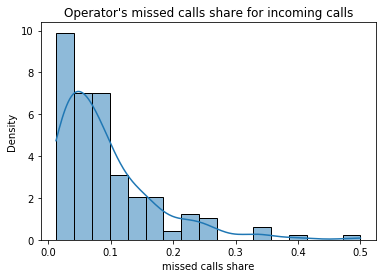

In [86]:
ax = sns.histplot(missed_share[missed_share>0],
                  kde=True, 
                  stat='density').set_title("Operator's missed calls share for incoming calls")
b = plt.xlabel("missed calls share")

In [87]:
missed_share[missed_share>0].describe()

count    169.000000
mean       0.091791
std        0.079430
min        0.012346
25%        0.034483
50%        0.071429
75%        0.118644
max        0.500000
Name: is_missed_call, dtype: float64

In [88]:
# for each operator get monthly share for missed incoming calls 
monthly_missed = calls_tariff.query('direction==0').groupby(['operator_id', 'month'])['is_missed_call'].apply(lambda x: x.sum()/x.count())
monthly_missed[monthly_missed>0].sample(10)

operator_id  month
960620.0     11       0.100000
924936.0     11       0.166667
899250.0     10       0.117647
934098.0     10       0.333333
934430.0     11       0.071429
928888.0     10       0.055556
944216.0     10       0.307692
917850.0     10       0.040000
885876.0     8        0.130435
937736.0     10       0.166667
Name: is_missed_call, dtype: float64

For those cases when operators missed calls the monthly share of missed calls has almost half of values from a sample >=10%.

## Comments:

- if we consider only cases when operators miss calls we've got:
    - on average ~9% (with std ~8%) share of missed calls 
    - 75% of operators have missed calls share <11.8%
    
So we can choose for a criteria of ineffective operators a threshold for the share of missed calls equal to 3Q ~12%.    

In [89]:
# filter operators above the threshold
bad_missed = missed_share[missed_share>0.12]
bad_missed.count()

42

In [90]:
len(set(bad_missed.index.get_level_values(level=0)) 
    - set(filtered_min_WT_month.index) 
    - set(filtered_mean_WT.index)
   - set(filtered_min_WT.index))

23

Out of 42 operators ineffective in terms of missed calls 23 are not in the waiting time based set. 

- Calculate mean share of outgoing calls per client/operator per day/month (use groupby() method).

In [91]:
# for each operator get daily mean share for outgoing calls 
daily_out = calls_tariff.groupby(['operator_id', 'date_trunc'])['direction'].apply(lambda x: x.sum()/x.count())
daily_out[daily_out>0].sample(10)

operator_id  date_trunc
947658.0     2019-11-14    1.000000
951492.0     2019-11-18    0.800000
919362.0     2019-10-06    1.000000
905430.0     2019-09-12    0.666667
900894.0     2019-10-18    0.666667
947620.0     2019-11-22    1.000000
889410.0     2019-08-30    0.666667
919202.0     2019-10-03    1.000000
896018.0     2019-09-19    1.000000
880026.0     2019-08-29    0.666667
Name: direction, dtype: float64

Among those cases when operators make outgoing calls more than half of outgoing calls share values from a sample >0.5

Now let's calculate mean share of outgoing calls among those who are supposed to make them.

In [92]:
out_share = calls_tariff.groupby(['operator_id'])['direction'].apply(lambda x: x.sum()/x.count())
out_share[out_share>0].mean()

0.7731072565469095

In [93]:
# get std for outgoing calls share 
out_share[out_share>0].std()

0.24350761756212466

We've got ~77% of mean operator's share of outgoing calls among operators who are supposed to make outgoing calls.


Seems that if operator has outgoing calls almost all of them should be of this type.

Let's study the share of outgoing calls per month period.

In [94]:
monthly_out = calls_tariff.groupby(['operator_id', 'month'])['direction'].apply(lambda x: x.sum()/x.count())
monthly_out[monthly_out>0].sample(10)

operator_id  month
928228.0     10       1.000000
904014.0     11       1.000000
888538.0     10       1.000000
959596.0     11       1.000000
937772.0     10       1.000000
926486.0     10       0.911111
939370.0     10       0.260870
954642.0     11       1.000000
941384.0     11       0.716667
914170.0     11       0.400000
Name: direction, dtype: float64

From a sample we see that most of monthly shares >0.5

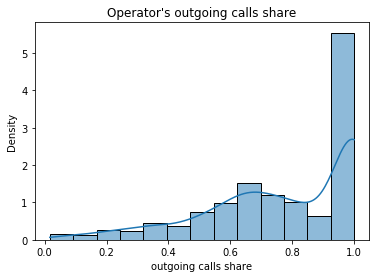

In [95]:
ax = sns.histplot(out_share[out_share>0],
                  kde=True, 
                  stat='density').set_title("Operator's outgoing calls share")
b = plt.xlabel("outgoing calls share")

In [96]:
out_share[out_share>0].describe()

count    882.000000
mean       0.773107
std        0.243508
min        0.016667
25%        0.625000
50%        0.823529
75%        1.000000
max        1.000000
Name: direction, dtype: float64

Let's get operators whose outgoing share below 0.5 (which is close to $(mean - std)$).
These operators might be ineffective in terms of low outgoing calls rate.

In [97]:
bad_out = out_share[(out_share<0.5) & (out_share>0)]
bad_out.count()

114

Let's get operators  which are unique to this criteria.

In [98]:
len(set(bad_out.index.get_level_values(level=0)) 
    - set(bad_missed.index.get_level_values(level=0)) 
    - set(filtered_min_WT_month.index) 
    - set(filtered_mean_WT.index)
   - set(filtered_min_WT.index))

81

32 out of 114 operators are already considered ineffective due to previous criteria while 82 operators are ineffective only in terms of outgoing calls. 

- Study  waiting time (for incoming calls) distribution for each tariff and build histograms.

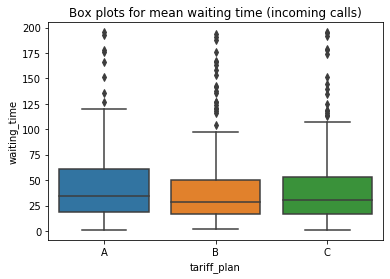

In [99]:
b = sns.boxplot(data=mean_WT.query('waiting_time<200 and waiting_time>0').sort_values('tariff_plan'), x='tariff_plan',y='waiting_time').set_title("Box plots for mean waiting time (incoming calls)")


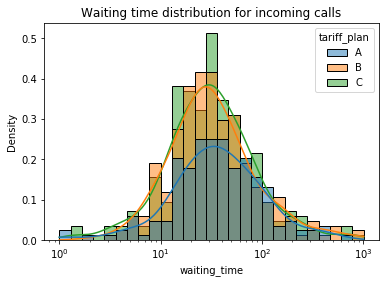

In [100]:
b = sns.histplot(mean_WT.query('waiting_time>0').sort_values('tariff_plan'),
             x='waiting_time',
             hue='tariff_plan',
             log_scale=True, 
              kde=True, 
              stat='density').set_title('Waiting time distribution for incoming calls')


From the above graphs seems that average waiting time values for tariffs A and C are a bit shifted to the right compared to tariff B.

- Make a statistical test: check if waiting times differ among tariffs. 

Test the following null-hypothesis:

$H_0$: mean waiting times for incoming calls are equal for all tariff plans. 

$H_a$: mean waiting times for incoming calls are not equal for all tariff plans.

We'll make 3 t-tests to compare pairs of tariffs. 

Let's set the familywise significance level $\alpha$ to 0.05 but for each particular test we'll need to apply a correction. Let's use the simplest **Bonferroni correction** and test each individual hypothesis at $\alpha_i = \alpha/3 = 0.05 / 3 = 0.0167$ 

In [101]:
# set alpha parameters
alpha = 0.05
alpha_i = alpha / 3
#build samples for the test
sampleA = calls_tariff.query('waiting_time>0 and direction==0 and tariff_plan=="A"')['waiting_time']
sampleB = calls_tariff.query('waiting_time>0 and direction==0 and tariff_plan=="B"')['waiting_time']
sampleC = calls_tariff.query('waiting_time>0 and direction==0 and tariff_plan=="C"')['waiting_time']
# perform t-tests
result = st.ttest_ind(sampleA, sampleB)
print('A and B: p-value: ', result.pvalue)
if result.pvalue < alpha_i:
    print('A and B: p-value is below significance level, so we have to reject the null hypothesis!')
else:
    print('A and B: p-value is above significance level, so we do not reject the null hypothesis!')
    
print('\n======\n')    
result = st.ttest_ind(sampleB, sampleC)
print('B and C: p-value: ', result.pvalue)
if result.pvalue < alpha_i:
    print('B and C: p-value is below significance level, so we have to reject the null hypothesis!')
else:
    print('B and C: p-value is above significance level, so we do not reject the null hypothesis!')    
print('\n======\n')        
result = st.ttest_ind(sampleA, sampleC)
print('A and C: p-value: ', result.pvalue)
if result.pvalue < alpha_i:
    print('A and C: p-value is below significance level, so we have to reject the null hypothesis!')
else:
    print('A and C: p-value is above significance level, so we do not reject the null hypothesis!')        

A and B: p-value:  1.746380032528399e-13
A and B: p-value is below significance level, so we have to reject the null hypothesis!


B and C: p-value:  2.1487949943040085e-18
B and C: p-value is below significance level, so we have to reject the null hypothesis!


A and C: p-value:  0.19971668952512708
A and C: p-value is above significance level, so we do not reject the null hypothesis!


We can't accept the null hypothesis so tariffs differ in mean waiting time. It's due to tariff B which differs from tariffs A and C in terms of wating time for incoming calls.

- Build a correlation matrix and display it

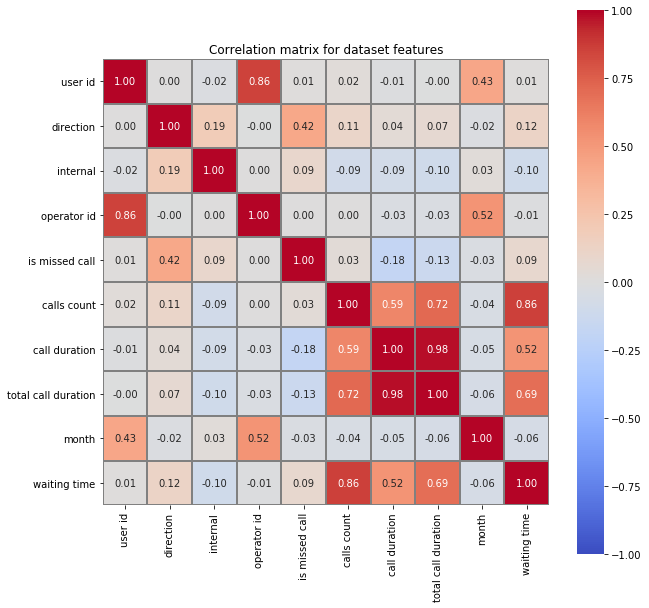

In [102]:
# build a correlation matrix
cm =calls_tariff.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm, annot = True, square=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax)
# add the title
b=ax.set_title("Correlation matrix for dataset features")
# get rid of _ in labels
b=ax.set_xticklabels(
    [a.get_text().replace('_',' ') for a in ax.get_xticklabels()])
b=ax.set_yticklabels(
    [a.get_text().replace('_',' ') for a in ax.get_xticklabels()])

We've got the following mostly (positively) correlated features:
- total call duration and call duration
- calls count and waiting time
- operator and user ids 

It's clear that call duration and total duration are strongly correlated because of the formula (total duration= call duration + waiting time).

Calls count correlates with waiting time which means that the calls count is call attempts number prior the caller was able to talk to operator. Such attempts consist of waiting time (except the last attempt which also includes time of the talk with operator). 

For our analysis we do not count call attempts (calls_count parameter) for the calculation of the number of calls handled by an operator.

For TOP10 clients build and study:
- mean waiting time (per operator) distribution for incoming calls.
- the number of calls per day distribution.
- mean share of missed incoming calls distribution.
- mean share of outgoing calls distribution.

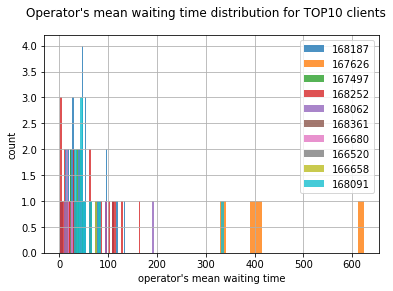

In [103]:
# get TOP10 clients
top10 = user_opcount.head(10).index
top10
# get mean waiting times for each operator from TOP10 clients
user_op_WT = calls_tariff.query('user_id in @top10 and waiting_time>0 and direction==0').groupby(['user_id','operator_id'])['waiting_time'].mean().reset_index()
# plot distributions
for user in top10:
    user_op_WT[user_op_WT['user_id']==user]['waiting_time'].hist(bins=50,alpha=0.8)
b = plt.xlabel("operator's mean waiting time")
b = plt.ylabel("count")    
b = plt.legend(top10)
b = plt.suptitle("Operator's mean waiting time distribution for TOP10 clients")    

We see that most of operators are concentrated below 100s (which matches our previous results for 97s threshold). Operators having mean waiting time more than ~100s can be treated as ineffective.

There's a client (167626) marked in orange whose operators stand out to the right. Taking our criteria it means that most of his operators who accept incoming calls are ineffective. Let's check his distribution.

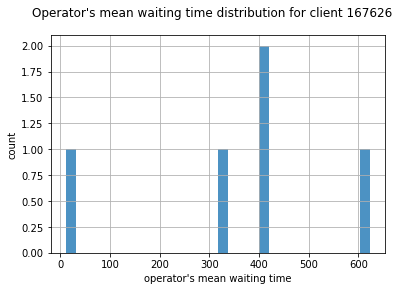

In [104]:
user_op_WT[user_op_WT['user_id']==167626]['waiting_time'].hist(bins=30,alpha=0.8)
b = plt.xlabel("operator's mean waiting time")
b = plt.ylabel("count")    
b = plt.suptitle("Operator's mean waiting time distribution for client 167626")    

For the client let's check the operators behavior for the real incoming calls.

In [105]:
client_month = calls_tariff.query('user_id == 167626 and waiting_time>0 and direction==0 and is_missed_call==False')
client_month[['operator_id', 'is_missed_call','call_duration', 'waiting_time']].sort_values('waiting_time')

operator_id  is_missed_call  call_duration  waiting_time
28561     919166.0           False              1             3
28335     919204.0           False              1             4
28739     919190.0           False             46             9
28614     919164.0           False              1             9
28350     919166.0           False            153            10
28819     919206.0           False              1            11
27737     919190.0           False            270            13
27730     919164.0           False             25            21
28466     919206.0           False              2            22
28824     919166.0           False              1            32
28670     919206.0           False              2            32
27978     919164.0           False           2870           341
28666     919166.0           False           5145           345
28712     919166.0           False           3396           355
27942     919204.0           False           6998           398
27957     919206.0           False           1838           430
28000     919164.0           False           4184           443
28673     919206.0           False           2117           457
27750     919164.0           False           2349           458
27953     919166.0           False           3232           463
27768     919206.0           False           2218           469
27813     919164.0           False           3649           469
28447     919164.0           False           6081           512
28283     919164.0           False           5166           520
28193     919164.0           False           5564           520
28821     919166.0           False           4100           535
28801     919206.0           False           2476           538
27998     919206.0           False           3261           552
27815     919206.0           False           2581           583
27860     919166.0           False           3811           619
28703     919204.0           False           5171           634
28316     919166.0           False           8501           643
28157     919166.0           False           9483           695
28626     919164.0           False           7578           698
28266     919206.0           False           3610           752
28189     919206.0           False           3703           756
27870     919204.0           False           5320           759
28631     919206.0           False           3304           792
28059     919166.0           False           9317           795
28544     919204.0           False          10324           869
28494     919204.0           False           8302           892
28468     919206.0           False           3244           936
28352     919204.0           False           9229           953
28128     919204.0           False          12340           957
28298     919204.0           False           9447          1013
28393     919206.0           False           4369          1015
28057     919204.0           False          11841          1061
28546     919166.0           False          10902          1122
28770     919204.0           False          15014          1745

Low values for waiting time mainly belong to calls with call duration of 1 or 2 seconds which can be treated as missed calls.

The most of calls lasted for hours (some even 4 hours) and have long waiting times.

It seems that for this particular client either almost all operators are ineffective (which is a rare case) because they spend a lot of time for the calls but they are supposed to work more quickly. As a consequense waiting time increases as customers have to wait until the operator finishes the call.

Another case: such long calls are normal for this client (for example if it's a psychological help service) and the long waiting time is due to lack of operators and it's not an operator's fault rather the client's one. 

So such cases should be investigated separately but for simplicity of analysis we'll apply universal thresholds to all clients to identify ineffective operators. 
An alternative approach for future research: try to elaborate individual criteria for each client.

- the number of calls per day distribution

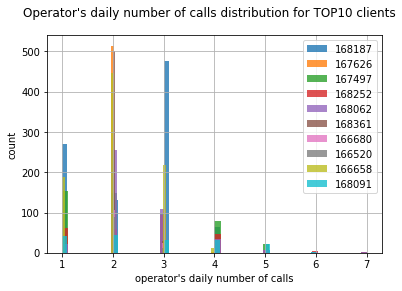

In [106]:
# get mean waiting times for each operator from TOP10 clients
user_op_ncalls = calls_tariff.query('user_id in @top10').groupby(['user_id','operator_id','date_trunc'])['waiting_time'].count().reset_index()
# plot distributions
user_op_ncalls.columns = ['user_id', 'operator_id', 'date', 'number of calls']
for user in top10:
    user_op_ncalls[user_op_ncalls['user_id']==user]['number of calls'].hist(bins=50,alpha=0.8)
b = plt.xlabel("operator's daily number of calls")
b = plt.ylabel("count")    
b = plt.legend(top10)
b = plt.suptitle("Operator's daily number of calls distribution for TOP10 clients")    

Mainly operators have 2 or 3 calls per day which matches our analysis above.

- mean share of missed incoming calls distribution

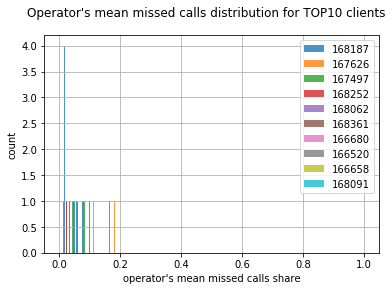

In [107]:
# get mean missed incoming calls share for each operator from TOP10 clients
user_op_missed_calls = calls_tariff.query('user_id in @top10 and direction==0').groupby(['user_id', 'operator_id', 'date_trunc'])['is_missed_call'].apply(lambda x: x.sum()/x.count()).reset_index()

# plot distributions
user_op_missed_calls.columns = ['user_id', 'operator_id', 'date', 'missed calls share']
user_op_missed_calls = user_op_missed_calls.groupby(['user_id', 'operator_id'])['missed calls share'].mean().reset_index()
for user in top10:
    user_op_missed_calls[(user_op_missed_calls['user_id']==user) & (user_op_missed_calls['missed calls share']>0)]['missed calls share'].hist(bins=50,alpha=0.8)
b = plt.xlabel("operator's mean missed calls share")
b = plt.ylabel("count")    
b = plt.legend(top10)
b = plt.suptitle("Operator's mean missed calls distribution for TOP10 clients")    

Mainly missed calls share is concentrated in the range below ~10% (which matches our criteria of 12% which we calculated above). Two operators to the right seem to be ineffective.

- mean share of outgoing calls distribution

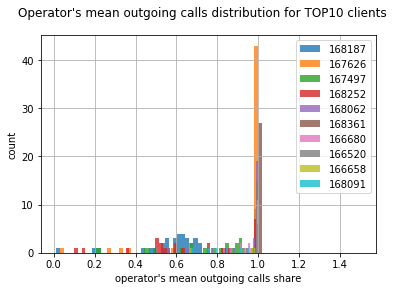

In [108]:
# get mean outgoing calls share for each operator from TOP10 clients
user_op_out_calls = calls_tariff.query('user_id in @top10').groupby(['user_id', 'operator_id', 'date_trunc'])['direction'].apply(lambda x: x.sum()/x.count()).reset_index()

# plot distributions
user_op_out_calls.columns = ['user_id', 'operator_id', 'date', 'outgoing calls share']
user_op_out_calls = user_op_out_calls.groupby(['user_id', 'operator_id'])['outgoing calls share'].mean().reset_index()
for user in top10:
    user_op_out_calls[(user_op_out_calls['user_id']==user) & (user_op_out_calls['outgoing calls share']>0)]['outgoing calls share'].hist(bins=50,alpha=0.8)
b = plt.xlabel("operator's mean outgoing calls share")
b = plt.ylabel("count")    
b = plt.legend(top10)
b = plt.suptitle("Operator's mean outgoing calls distribution for TOP10 clients")    

We see that the most of operators are concentrated above 0.5 value so this threshold was chosen correctly to define ineffectiveness.

## Conclusions

- We consider 290 clients with 1092 operators distributed among them.
- Typically a client has from 1 to 4 operators.
- Missed incoming calls have a share of ~3.2% of all incoming calls.
- Waiting time for incoming calls has 38s median and 97s mean (and 3Q) values. As a criteria for ineffective operators we can take mean waiting time of more than 3Q value (**97s**).
- Mean waiting times differ for tariffs A, B and C.
- We've got 3 subsets of operators based on waiting time analysis:
    - the most ineffective in the sense of long daily mean waiting time (11 operators with daily mean waiting time > 97s)
    - moderately ineffective (84 operators with mean waiting time >97s)
    - month-based  ineffective (48 operators with min monthly average waiting time >60s)
- Considering only cases when operators miss calls we've got:
    - on average ~9% (with std ~8%) of calls are missed
- As a criteria for ineffective operators we can choose a threshold for the average monthly share of missed calls equal to mean = **12%**.
- Out of 42 operators ineffective in terms of missed calls 23 are not in the waiting time based set. 
- Among all operators who are supposed to make outgoing calls the mean share of outgoing calls is 77% with std ~24% (almost all calls should be outgoing).  
- Operators whose outgoing share below **0.5** are considered ineffective.
- 81 out of 114 operators operators are ineffective only in terms of outgoing calls while the rest are also ineffective in terms of previous criteria.
- Totally we've identified **247** ineffective operators which is **~23%**  of all operators. The degree of ineffectiveness was also proposed by splitting the operators into subsets based on the different criteria.
- For TOP10 clients we checked distributions of the main KPIs among operators and confirmed that out criteria are reasonable.
- We also noticed that the long waiting time might be due to lack of operators and it's not an operator's fault rather the client's one. So such cases should be investigated separately but for simplicity of analysis we'll apply universal thresholds to all clients to identify ineffective operators. An alternative approach for future research: try to elaborate individual criteria for each client.

<a id='step4'></a>

## Step 4. Cluster analysis

-  Per each operator calculate mean values of:
    - waiting_time 
    - direction
    - internal
    - calls_count
    - share of missed incoming calls

    
- Scale the features, calculate standardized feature matrix (using linkage) and plot the dendrogram.
- Determine the number of clusters.
- Use K-means algorithm to get cluster labels.
- Look at mean values for each cluster and determine clusters with ineffective operators.
- Find thresholds for:
    - waiting time
    - share of missed incoming calls
    - share of outgoing calls 
   
   for ineffective operators and compare the results with the previous step.

-  Per each operator calculate mean values of:
    - waiting_time 
    - waiting_time for incoming calls
    - direction
    - internal
    - calls_count
    - is_missed_call
- Per each operator calculate share of missed incoming calls

In [109]:
X = calls_tariff.groupby('operator_id').agg({'waiting_time': 'mean', 'direction':'mean','internal':'mean','calls_count':'mean', 'is_missed_call':'mean' })
# calculate share of missed incoming calls per operator
X['missed_share'] = calls_tariff.groupby(['operator_id', 'direction'])['is_missed_call'].apply(lambda x: x.sum()/x.count()).reset_index().query('direction==0').groupby('operator_id')['is_missed_call'].max()
X['missed_share'] = X['missed_share'].fillna(0)
# calculate mean waiting time for incoming calls per operator
X['waiting_time_inc'] = calls_tariff.groupby(['operator_id', 'direction'])['waiting_time'].mean().reset_index().query('direction==0').groupby('operator_id')['waiting_time'].max()
X['waiting_time_inc'] = X['waiting_time_inc'].fillna(0)

- Scale the features, calculate standardized feature matrix (using linkage) and plot the dendrogram.

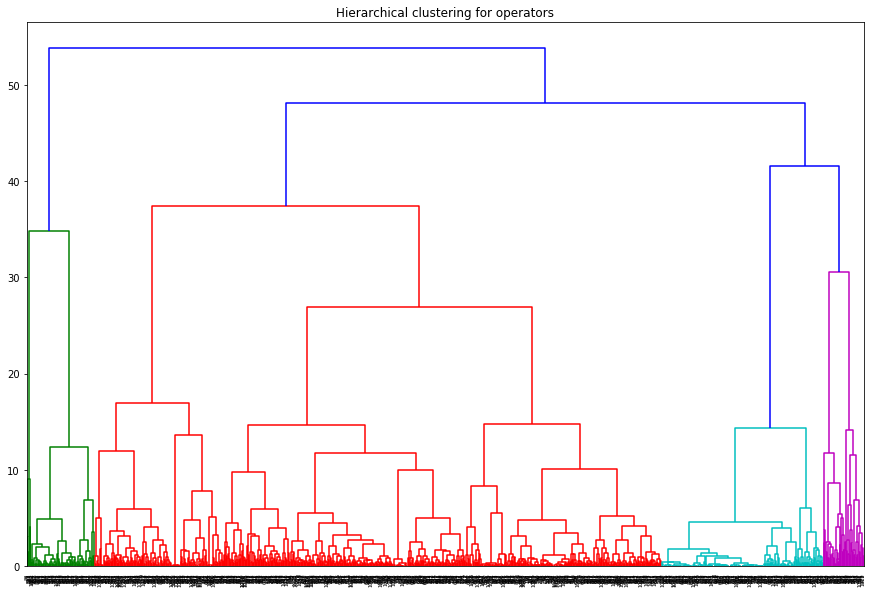

In [110]:
# scale the features
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
# get the standardized feature matrix
linked = linkage(X_st, method = 'ward') 
# plot a dendrogram
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for operators')
plt.show() 

From the dendrogram we see that we can divide the operators into 5 clusters.

- Use K-means algorithm to get cluster labels.

In [111]:
# setting the number of clusters as 5
km = KMeans(n_clusters = 5, random_state=0) 
# applying the algorithm to the data and forming a cluster vector 
labels = km.fit_predict(X_st) 

- Look at mean values for each cluster and determine clusters with ineffective operators.

In [112]:
# Calculate mean feature values
X['labels'] = labels
X.groupby('labels').agg(['mean']).stack(level=0).unstack(level=0)

mean                                              
labels                      0          1           2          3           4
waiting_time      1645.104771  25.308587  149.163057  36.539276  223.134643
direction            0.984781   0.839045    0.823528   0.095961    0.505421
internal             0.025846   0.695069    0.078910   0.040417    0.088852
calls_count         81.121295   2.240964    8.883201   2.414383   14.025200
is_missed_call       0.500106   0.380673    0.408893   0.048397    0.307303
missed_share         0.005718   0.000552    0.005289   0.009160    0.143185
waiting_time_inc     4.172324  19.788779   27.139269  38.617489  231.059204

In [113]:
X.reset_index().groupby('labels')['operator_id'].count()

labels
0     79
1    139
2    517
3    290
4     67
Name: operator_id, dtype: int64

## Conclusions:

- **Cluster 4** looks like  a cluster of ineffective operators (67 operators in total). Some operators from **cluster 3** have low outgoing calls rate but

- **cluster 4** is ineffective in terms of:
    - waiting time, 
    - share of outgoing calls and 
    - share of incoming missed calls
- Cluster 4 average values for percentage of outgoing calls  (50%) and incoming missed calls (14%) match our thresholds defined above (50% and 13% correspondingly). The threshold for waiting time (97s) is below the average value (231s) waiting time for incoming calls. 
- So our criteria match the clusters average values.

- Find unique users in cluster 4 absent from our sets of ineffective operators.

In [114]:
new_ops = (set(X.query('labels==4').index) 
    - set(bad_out.index.get_level_values(level=0)) 
    - set(bad_missed.index.get_level_values(level=0)) 
    - set(filtered_min_WT_month.index) 
    - set(filtered_mean_WT.index)
    - set(filtered_min_WT.index))
len(new_ops)    

0

In [115]:
len(set(X.query('labels==4').index) 
    - set(bad_missed.index.get_level_values(level=0)) 
    - set(filtered_min_WT_month.index)
    - set(filtered_mean_WT.index))

0

## Conclusions:

- So all operators identified as ineffective in the cluster analysis are already contained in the above sets. 
- All the operators from cluster 4 are covered by just 3 sets:
    - Ineffective operators based on average waiting time for incoming calls
    - Ineffective operators based on min average monthly waiting time for incoming calls
    - Ineffective operators based on share of missed calls.

<a id='step5'></a>

## Step 5.  Ineffective operators analysis

- Based on criteria from the previous step get the list of ineffective operators.
- Build time-based graphs for each ineffective operator to check if waiting time changed during time.
- Make a statistical test to check that ineffective operators share does not depend on tariff.

Test the following null-hypothesis $H_0$: proportions of ineffective operators for all tariffs are equal. 

- Based on criteria from the previous step get the list of ineffective operators

In [116]:
# Get several lists based on criteria
long_min_WT_daily = list(filtered_min_WT.index)
long_mean_WT_daily = list(set(filtered_mean_WT.index)
                    - set(filtered_min_WT.index))
long_mean_WT_monthly = list(set(filtered_min_WT_month.index) 
                    - set(filtered_mean_WT.index)
                    - set(filtered_min_WT.index))

high_rate_missed_calls = list(set(bad_missed.index.get_level_values(level=0)) 
                        - set(filtered_min_WT_month.index) 
                        - set(filtered_mean_WT.index)
                        - set(filtered_min_WT.index))
low_outgoing_calls = list(set(bad_out.index.get_level_values(level=0)) 
                        - set(bad_missed.index.get_level_values(level=0)) 
                        - set(filtered_min_WT_month.index) 
                        - set(filtered_mean_WT.index)
                        - set(filtered_min_WT.index))
long_min_WT_daily

[882688.0,
 906406.0,
 919204.0,
 919206.0,
 919794.0,
 921318.0,
 937362.0,
 961552.0,
 969272.0,
 969294.0,
 970254.0]

In [117]:
long_mean_WT_daily[:5]

[919552.0, 882690.0, 919554.0, 937736.0, 899082.0]

In [118]:
long_mean_WT_monthly[:5]

[898560.0, 922114.0, 908162.0, 958468.0, 970244.0]

In [119]:
high_rate_missed_calls[:5]

[924936.0, 937874.0, 941844.0, 894614.0, 948758.0]

In [120]:
low_outgoing_calls[:5]

[930816.0, 891908.0, 930820.0, 904200.0, 914440.0]

In [121]:
inefficient_ops = long_min_WT_daily + long_mean_WT_daily + long_mean_WT_monthly + high_rate_missed_calls +  low_outgoing_calls
len(inefficient_ops)

247

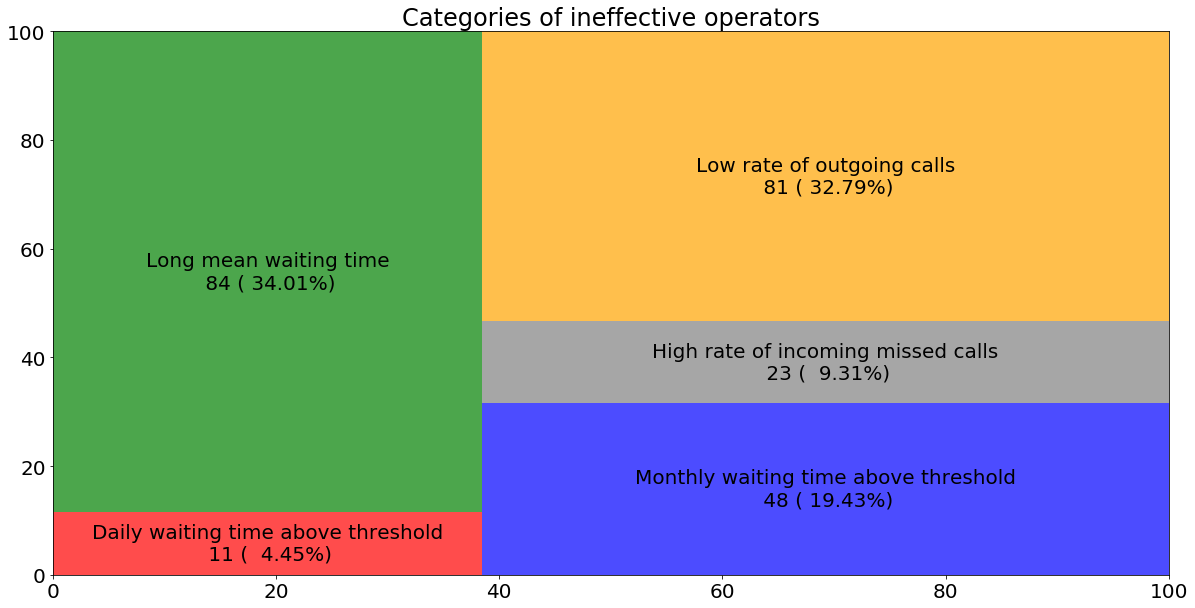

In [122]:
# Let's visualize the categories using treemap
classes = [len(long_min_WT_daily), len(long_mean_WT_daily), len(long_mean_WT_monthly), len(high_rate_missed_calls), len(low_outgoing_calls) ]
labels = ['Daily waiting time above threshold', 'Long mean waiting time',
          'Monthly waiting time above threshold', 'High rate of incoming missed calls',
         'Low rate of outgoing calls']
labels = ['{: <20}\n {} ({:>6.2f}%)'.format(a[0], a[1],100*a[1]/sum(classes)) for a in zip(labels,classes)]
plt.rc('font', size=20)
plt.figure(figsize=(20,10))

squarify.plot(sizes=classes, label=labels, alpha=0.7, color=["red","green","blue", "grey","orange"])
b = plt.title('Categories of ineffective operators')
plt.show()

- Build time-based graphs for each ineffective operator to check if waiting time for incoming calls changed during time.

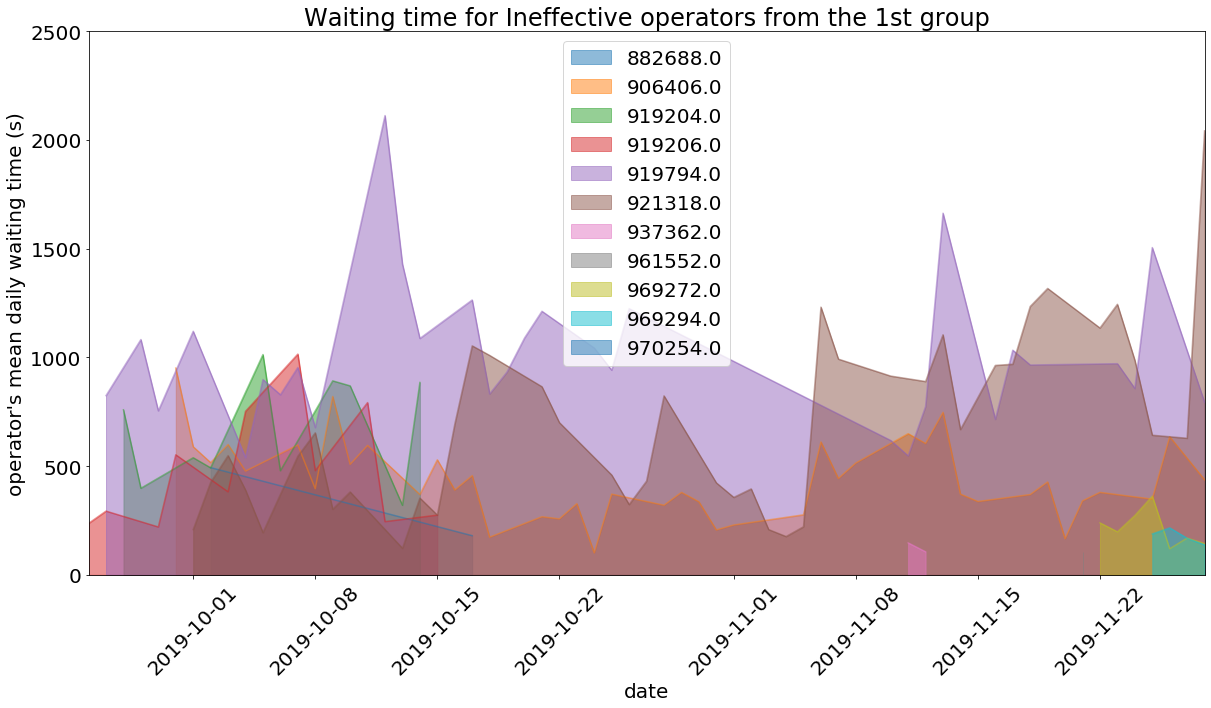

In [123]:
# Let's build mean daily waiting time distribution over the dates for each operator
group1 = calls_tariff.query('operator_id in @long_min_WT_daily and direction==0').groupby(['operator_id','date_trunc'])['waiting_time'].mean()
fig, ax = plt.subplots()

for op in long_min_WT_daily:
    group1.reset_index().query('operator_id==@op').plot(kind='area', x='date_trunc',y='waiting_time', ylim=(0,2500), label=op,figsize=(20, 10),  stacked=False, ax=ax)
b = plt.xticks(rotation=45)    
b = plt.ylabel("operator's mean daily waiting time (s)")
b = plt.xlabel("date")
b= plt.title('Waiting time for Ineffective operators from the 1st group')

There're no any patterns in waiting times: the values bounce having peaks and troughs during the period but it does not drop below 97 seconds. Operator 919794 is the most ineffective having the longest waiting times.

- Make a statistical test to check that ineffective operators share does not depend on tariff.

Test the following null-hypothesis $H_0$: proportions of ineffective operators for all tariffs are equal. 

$H_a$: proportions of ineffective operators for all tariffs are not equal. 

As above let's set the familywise significance level $\alpha$ to 0.05 but for each particular test we'll need to apply a correction. Let's use the simplest **Bonferroni correction** and test each individual hypothesis at $\alpha_i = \alpha/3 = 0.05 / 3 = 0.0167$ 

In [124]:
# implement function to make a statistical test for proportions of ineffective operators 
# beetween two tariffs 
# function takes tariff names and a significance level
# it gets the values from the table calls_tariff (see above)
def check_hypothesis(tariff1, tariff2, alpha=0.05):
    #let's start with successes, using 
    successes1=calls_tariff.query('tariff_plan == @tariff1 and operator_id in @inefficient_ops')['operator_id'].nunique()
    successes2=calls_tariff.query('tariff_plan == @tariff2 and operator_id in @inefficient_ops')['operator_id'].nunique()
    
    #for trials we use all operators of a certain tariff
    trials1=calls_tariff.query('tariff_plan == @tariff1')['operator_id'].nunique()
    trials2=calls_tariff.query('tariff_plan == @tariff2')['operator_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

# the difference between the datasets' proportions  
    difference = p1 - p2
    
# calculating the statistic in standard deviations of the standard normal 
# distribution    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

# setting up the standard normal distribution (mean 0, standard deviation 1
    distr = st.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)
    
    if (p_value < alpha):
        print("Reject H0 for and groups",tariff1,tariff2)
    else:
        print("Fail to Reject H0 for groups",tariff1,tariff2)  

In [125]:
# perform statistical tests for tariff pairs
check_hypothesis('A','B',alpha_i)
check_hypothesis('B','C',alpha_i)
check_hypothesis('A','C',alpha_i)

p-value:  0.5861612331341699
Fail to Reject H0 for groups A B
p-value:  0.0761972353695144
Fail to Reject H0 for groups B C
p-value:  0.2624449245296403
Fail to Reject H0 for groups A C


We failed to reject the null hypothesis so it seems proportion of ineffective operators does not differ among all three tariffs.

<a id='step6'></a>

## Step 6. Make conclusions.

- Provide criteria to determine ineffective operators
- Identify the ineffective operators from the dataset.


- We've defined 5 categories of ineffective operators:
    1. The most ineffective operators in terms of waiting time: operators whose average day waiting time does not drop below 97 seconds.
    2. Moderately ineffective operators in terms of mean waiting time: operators whose average  waiting time more than 97 seconds.
    3. Other ineffective operators in terms of monthly waiting time: operators whose average waiting time over month does not drop below 60 seconds.
    4. Ineffective operators in terms of missed incoming calls: operators whose share of missed incoming calls exceeds 12%.
    5. Ineffective operators in terms of outgoing calls: operators supposed to make outgoing calls whose share of outgoing calls below 50%.
- Totally there're 247 ineffective operators (~23% out of all operators) split between categories as follows:
    1. 11 operators (4.5% of all ineffective operators)
    2. 84 operators (34% of all ineffective operators)
    3. 48 operators (19.5% of all ineffective operators)
    4. 23 operators (9.3% of all ineffective operators)
    5. 81 operators (32.7% of all ineffective operators)


<a id='ref'></a>

## References
<a id='fn1'></a>
1. Call center statistics that count (https://www.cloudtalk.io/blog/call-center-statistics-that-count)
<a id='fn2'></a>
2. Top 10 Call Centre Metrics and What They Mean to You (https://www.the-cma.org/disciplines/analytics/archive/top-10-call-centre-metrics)
<a id='fn3'></a>
3. 12 Call Center KPIs to Track for Customer Succ
ess (https://www.talkdesk.com/blog/12-call-center-kpis-to-track-for-success/)
<a id='fn4'></a>
4. An Overview of Talkdesk Reporting Metrics and Descriptions (https://www.talkdesk.com/blog/an-overview-of-talkdesk-reporting-metrics-and-descriptions/)
<a id='fn5'></a>
5. Call Center KPI Benchmarks by Industry (https://www.talkdesk.com/resources/infographics/call-center-kpi-benchmarks-by-industry/)